# First HW part
* Historical Data Analysis
* Experiments

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
hist_data = pd.read_csv("temperature_data.csv")
hist_data.shape

(54750, 4)

In [3]:
hist_data.sample(6)

,city,timestamp,temperature,season
45704,Mumbai,2015-03-20,21.836685,spring
45500,Mumbai,2014-08-28,35.519547,summer
48230,Cairo,2012-02-20,14.322762,winter
9535,Paris,2016-02-14,2.588359,winter
30630,Rio de Janeiro,2013-12-01,18.914961,winter
52053,Mexico City,2012-08-11,11.682768,summer


In [4]:
hist_data.dtypes

city            object
timestamp       object
temperature    float64
season          object
dtype: object

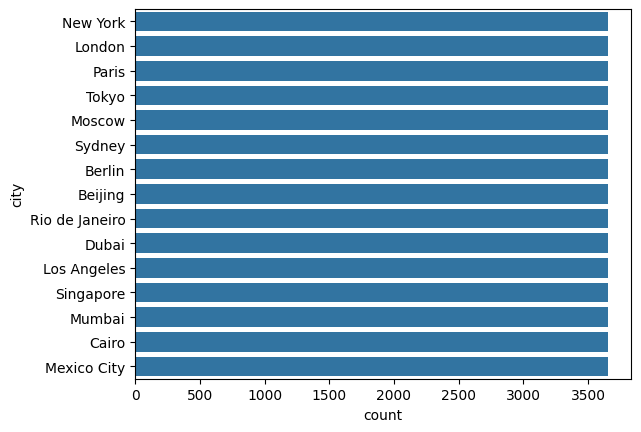

In [5]:
sns.countplot(data=hist_data, y="city");

## Тяжёлая функция

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
def heavy_analysis_func(df:pd.DataFrame, city:str|None = None, window_size = 30):
    if city is not None:
        df = df[df.city == city]
    df = df.sort_values(by='timestamp')

    main_stats = df['temperature'].agg(['mean', 'max', 'min'])

    df[['mean_30ws', 'std_30ws']] = df['temperature'].rolling(
                        window=window_size, center=True, 
                        closed='neither', min_periods=1,
                        ).agg(['mean', 'std'])
    
    cond01 = df.temperature > df.mean_30ws + 2 * df.std_30ws
    cond02 = df.temperature < df.mean_30ws - 2 * df.std_30ws
    anomalies = df[cond01 | cond02].index
    
    season_profile = df.groupby('season').agg(
        temp_mean=('temperature', 'mean'),
        temp_std=('temperature', 'std'),
    )
    
    temp = df['temperature']
    trend = int(LinearRegression().fit(np.arange(len(temp)).reshape(-1, 1), temp).coef_[0] >= 0)

    return city, main_stats, season_profile, trend, anomalies

In [8]:
heavy_analysis_func(hist_data, "Moscow")

('Moscow',
 mean     5.263984
 max     35.515405
 min    -24.706892
 Name: temperature, dtype: float64,
         temp_mean  temp_std
 season                     
 autumn   8.108102  5.053306
 spring   5.093212  5.136862
 summer  17.917231  4.732645
 winter -10.371600  4.881839,
 1,
 Index([14601, 14637, 14787, 14826, 14884, 14896, 14915, 14949, 15061, 15083,
        ...
        17875, 17887, 17906, 17933, 17968, 18021, 18160, 18181, 18200, 18207],
       dtype='int64', length=106))

In [13]:
city, stats, s_profile, trend, ano = heavy_analysis_func(hist_data, "Moscow")

In [14]:
s_profile

,temp_mean,temp_std
season,,
autumn,8.108102,5.053306
spring,5.093212,5.136862
summer,17.917231,4.732645
winter,-10.371600,4.881839


## Эксперименты по распараллеливанию

Как я поняла задание: тут нужно сравнить базовый вариант без распрараллеливания и какой-то тип параллельности (только один). 

У нас тут CPU-bound

In [9]:
%%time
for city in hist_data.city.unique():
    heavy_analysis_func(hist_data, city)

CPU times: user 136 ms, sys: 2.35 ms, total: 139 ms
Wall time: 137 ms


In [10]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def many_processes_analysis_func(df: pd.DataFrame, cities: list = None, window_size=30):
    if cities is None:
        cities = df.city.unique()

    results = []

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(heavy_analysis_func, df, city, window_size) for city in cities]
        for future in as_completed(futures):
            results.append(future.result())

    return None
    # return results

In [11]:
%%time
many_processes_analysis_func(hist_data)

CPU times: user 105 ms, sys: 173 ms, total: 277 ms
Wall time: 323 ms


**Синхронный подход**:

```python
CPU times: user 192 ms, sys: 10.8 ms, total: 203 ms
Wall time: 199 ms
```

**Многопроцессноть**:

```python
CPU times: user 94 ms, sys: 189 ms, total: 283 ms
Wall time: 329 ms
```


* **С многопроцессностью получилось медленнее**, видимо, из-за того, что вычисления недостаточно тяжёлые для получения выгоды. 

* **Мы просто потратили ресурсы на распределение ресурсов**. Моя метафора: это как брать налоги, когда государство не нужно из-за слишком простого устройства общества. Они тогда бандиты получаются, которые за счёт других живут

## Train API Call

In [12]:
import requests

In [13]:
API_KEY = 'aab31f6cd078f1d1e4ca7ece5964d8ac'

In [32]:
def get_latitude_and_longitude(city_name, api_key):
    base_url = f"http://api.openweathermap.org/geo/1.0/direct"
    params = {
        'q': city_name,
        'appid': api_key,
    }
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        response = response.json()[0]
        return response['lat'], response['lon']
    else:
        raise Exception(f"Ошибка запроса: {response.status_code}")

In [33]:
get_latitude_and_longitude(city_name="Moscow", api_key=API_KEY)

(55.7504461, 37.6174943)

In [28]:
def get_weather_data(lat, lon, api_key):
    base_url = f"https://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,  # широта
        'lon': lon,  # долгота
        'appid': api_key,
        'units': 'metric',
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        return response.json()['main']['temp']
    else:
        raise Exception(f"Ошибка запроса: {response.status_code}")
    
    

In [29]:
get_weather_data(lat=55.7522, lon=37.6156, api_key=API_KEY)

13.91